In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# okt
!pip install konlpy

# 띄어쓰기
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [3]:
from pykospacing import Spacing
spacing = Spacing()

from konlpy.tag import Okt
okt = Okt()

# 중복, 한글 외 제거
def duplicatesRemove(data) :
  #data.drop_duplicates(subset = ['comment'], inplace=True) # 중복 제거
  data['comment'] = data['comment'].str.replace("[^가-힣|ㄱ-ㅎ|ㅏ-ㅣ|0-9 ]","") # 한글+숫자 정규표현식
  data['comment'] = data['comment'].str.replace('^ +', "") # 공백은 empty 값으로 변경
  data['comment'].replace('', np.nan, inplace=True) #공백은 Null 값으로 변경
  data = data.dropna(how='any') # Null 값 제거
  data.reset_index(drop=True, inplace=True)
  return data

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
stopwords = ['이', '듯', '으로', '고', '인', '와', '하다', '의', '한', '다,', '은', '를', '가', '좀', 
             '자', '게', '도', '과', '네', '들', '는', '지', '잘', '에', '을', '걍', '임', '하']
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [5]:
import pandas as pd
import numpy as np

# 전처리

In [6]:
route = '/content/drive/MyDrive/참빛설계[조랑말]'
data = pd.read_csv(route+'/csv/integrated_data.csv')
data.columns = ['index', 'comment', 'sentiment', 'token']
data = data[['index', 'token', 'sentiment', 'comment']]
data

,index,token,sentiment,comment
0,0,"['ㄹㅇ', '본방', '보고', '싶은데', '나', '만', '보면', '지는'...",0.0,ㄹㅇ 본방 보고 싶은데 나만 보면 지는 것 같아서 절대 안 볼거임 ㅜㅠㅠ
1,1,"['난', '근데', '이미', '짐작', '은', '했음']",0.0,난 근데 이미 짐작은 했음
2,2,"['주작', '이', '여도', '보기', '좋네']",0.0,주작이 여도 보기 좋네
3,3,"['설정', '인건', '알겠는데', '가슴', '찡하다', '요', 'ㅜㅜ', '...",0.0,설정 인건 알겠는데 가슴 찡하다 요ㅜㅜ 영상 항상 잘 보고 있습니당
4,4,"['너무', '소중한', '목소리']",0.0,너무 소중한 목소리
...,...,...,...,...
23543,23543,"['정우성', '이', '간첩', '같다', '안', '그럼', '저렇게', '다'...",1.0,정우성이 간첩 같다 안 그럼 저렇게 다 가진 사람이 여 자가 없냐
23544,23544,"['김제동', '이', '유튜브', '시작', '했은데', '유재석', '이효리',...",1.0,김제동이 유튜브 시작했은데 유재석 이효리 오픈 메세지 보냈다이놈들도 빨갱이 다
23545,23545,"['유해진', '개새끼', '지']",1.0,유해진 개새끼지
23546,23546,"['두', '번', '째', '는', '최악', '이', '다', '눈치', '도'...",1.0,두 번째는 최악이 다 눈치도 없고 머리 속도 통통빈 듯


In [7]:
data['sentiment'].value_counts()

0.0    11855
1.0    11693
Name: sentiment, dtype: int64

In [8]:
# str to list
for i in range(len(data)):
  if i % 1000 == 0:
    print(i)
  data['token'][i] = ast.literal_eval(data['token'][i])
print('done')

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
done


In [9]:
token = data.iloc[:, :3]
token

,index,token,sentiment
0,0,"[ㄹㅇ, 본방, 보고, 싶은데, 나, 만, 보면, 지는, 것, 같아서, 절대, 안,...",0.0
1,1,"[난, 근데, 이미, 짐작, 은, 했음]",0.0
2,2,"[주작, 이, 여도, 보기, 좋네]",0.0
3,3,"[설정, 인건, 알겠는데, 가슴, 찡하다, 요, ㅜㅜ, 영상, 항상, 잘, 보고, ...",0.0
4,4,"[너무, 소중한, 목소리]",0.0
...,...,...,...
23543,23543,"[정우성, 이, 간첩, 같다, 안, 그럼, 저렇게, 다, 가진, 사람, 이, 여, ...",1.0
23544,23544,"[김제동, 이, 유튜브, 시작, 했은데, 유재석, 이효리, 오픈, 메세지, 보냈다,...",1.0
23545,23545,"[유해진, 개새끼, 지]",1.0
23546,23546,"[두, 번, 째, 는, 최악, 이, 다, 눈치, 도, 없고, 머리, 속도, 통통, ...",1.0


In [10]:
train_data = token.sample(frac=0.8, random_state=2021)
temp = pd.concat([train_data, token])
test_data = temp.drop_duplicates(['index'], keep=False)
print(len(train_data), len(test_data))

18838 4710


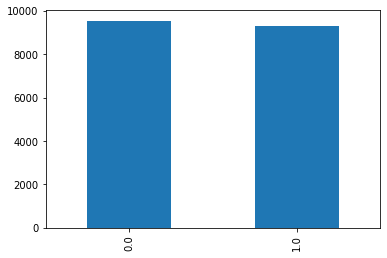

In [11]:
train_data['sentiment'].value_counts().plot(kind = 'bar')

In [12]:
X_train  = []
for token in train_data['token']:
    print(token)
    temp_X = [word for word in token if not word in stopwords] # 불용어 제거
    print('-> ', temp_X)
    X_train.append(temp_X)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['못', '생긴', '게', '쳐', '마누라', '잘', '만나가', '신영수', '졸라', '못', '생김']
->  ['못', '생긴', '쳐', '마누라', '만나가', '신영수', '졸라', '못', '생김']
['와', '도입', '부', '지석진', '목소리', '가', '너무', '좋은데', '진짜', '내', '가', '좋아하는', '목소리', '타입', '인가', '봐', '처음', '알', '앗어']
->  ['도입', '부', '지석진', '목소리', '너무', '좋은데', '진짜', '내', '좋아하는', '목소리', '타입', '인가', '봐', '처음', '알', '앗어']
['사과', '티비', '우리', '동년배', '들', '모르는', '남자', '없던', '데']
->  ['사과', '티비', '우리', '동년배', '모르는', '남자', '없던', '데']
['님', '정신', '승리', '하는', '거', '개웃', '김', '평생', '그렇게', '사세요', 'ㅋㅋㅋ', '진짜', '말', '한마디', '한마디', '나', '는', '무식합니다', '티', '내는', '거', '개', '웃김']
->  ['님', '정신', '승리', '하는', '거', '개웃', '김', '평생', '그렇게', '사세요', 'ㅋㅋㅋ', '진짜', '말', '한마디', '한마디', '나', '무식합니다', '티', '내는', '거', '개', '웃김']
['셀럽', '파이브', '자체', '가', '극', '혐들']
->  ['셀럽', '파이브', '자체', '극', '혐들']
['개새끼', '나', '같으면', '얼굴', '보자마자', '죽인다']
->  ['개새끼', '나', '같으면', '얼굴', '보자마자', '죽인다']
['코뉴', '어', '헐', '그니까', '요', '약간', '목소리', '가', '김연우', '성우', '님', '재질', '김연우', '성우'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['아씨', '발']
->  ['아씨', '발']
['코로나', '어쩔', '꺼야', '코로나']
->  ['코로나', '어쩔', '꺼야', '코로나']
['너무', '웃겨서', '어떻게', '웃어야', '될지', '모르겠네']
->  ['너무', '웃겨서', '어떻게', '웃어야', '될지', '모르겠네']
['아오', '밥', '풀', '소', '울', '채널', '하루', '에', '몇', '번', '배출', '하게', '하는', '거지', 'ㄱㅅ', '흔드는', '거', '진짜', '대', '박', '인데']
->  ['아오', '밥', '풀', '소', '울', '채널', '하루', '몇', '번', '배출', '하게', '하는', '거지', 'ㄱㅅ', '흔드는', '거', '진짜', '대', '박', '인데']
['우리나라', '우승', '도', '기', '쁘', '고', '위', '아', '위스', '도', '질', '좋은', '활', '만들어서', '다른', '나라', '도', '사용', '하는', '걸', '보니', '기', '쁘네', '요']
->  ['우리나라', '우승', '기', '쁘', '위', '아', '위스', '질', '좋은', '활', '만들어서', '다른', '나라', '사용', '하는', '걸', '보니', '기', '쁘네', '요']
['다', '죽고', '특', '진하면', '뭐', '하냐고', 'ㅅㅂ', '국', '개', '의원', '호주머니', '로', '들어갈', '돈', '으로', '소방', '장비', '첨단', '화', '했으면', '안', '죽는', '거', '아니냐고', '이', '국', '개', '의원', '새끼', '들', '아']
->  ['다', '죽고', '특', '진하면', '뭐', '하냐고', 'ㅅㅂ', '국', '개', '의원', '호주머니', '로', '들어갈', '돈', '소방', '장비', '첨단', '화', '했으면', '안

In [13]:
X_test  = []
for token in test_data['token']:
    print(token)
    temp_X = [word for word in token if not word in stopwords] # 불용어 제거
    print('-> ', temp_X)
    X_test.append(temp_X)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['사먹는', '음식', '한', '번', '씩', '걱정', '되지만', '저', '집', '보고', '많은', '걸', '느끼네요']
->  ['사먹는', '음식', '번', '씩', '걱정', '되지만', '저', '집', '보고', '많은', '걸', '느끼네요']
['저런', '거', '하다가', '백종원', '화병', '나서', '제명', '에', '못', '죽는', '거', '아니냐']
->  ['저런', '거', '하다가', '백종원', '화병', '나서', '제명', '못', '죽는', '거', '아니냐']
['역시', '는', '역시', '김종국', '난', '런닝맨', '아니면', '미', '우세', '를', '본다', '아니면', '다', '본', '다', '댓글', '로', '그리고', '응원', '합니다']
->  ['역시', '역시', '김종국', '난', '런닝맨', '아니면', '미', '우세', '본다', '아니면', '다', '본', '다', '댓글', '로', '그리고', '응원', '합니다']
['야호']
->  ['야호']
['아', '속상하다', '우울증', '참', '무서운', '병', '이구나']
->  ['아', '속상하다', '우울증', '참', '무서운', '병', '이구나']
['근육', '맨']
->  ['근육', '맨']
['일반', '음식점', '도', '뒤지게', '힘든데', '저런', '곳', '은', '진짜', '뒤질', '듯']
->  ['일반', '음식점', '뒤지게', '힘든데', '저런', '곳', '진짜', '뒤질']
['매일', '운동', '끌려다니고', '싶다']
->  ['매일', '운동', '끌려다니고', '싶다']
['데프콘', '먹방', '잘', '하네', 'ㅋㅋㅋㅋㅋ', '14748748', 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']
->  ['데프콘', '먹방', '하네', 'ㅋㅋㅋㅋㅋ', '14748748', 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋ

In [14]:
print(X_train[:3])
print(X_test[:3])
print(len(X_train), len(X_test))

[['너무', '사랑스러워', '요', 'ㅠㅠㅠㅠㅠ'], ['몸', '아무', '해', '끼치지', '않고', '기', '절', '시키는', '방법', '알', '다녀야', '겠어요'], ['사람', '전과자', '인데', '죄목', '심장', '폭행죄']]
[['너무', '소중한', '목소리'], ['진짜', '로', '궁금한', '거', '사진', '찍고', '폰', '왜', '발', '로', '찬', '거지'], ['수록', '곡', '퀄리티', '장난', '아니네', 'ㄷㄷ']]
18838 4710


# 정수인코딩

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
print(tokenizer.word_index)
od=tokenizer.word_counts
lista = sorted(od.items())
print(lista)

{'다': 1, '거': 2, '진짜': 3, '안': 4, '하는': 5, '너무': 6, '나': 7, '것': 8, 'ㅋㅋ': 9, '저': 10, '로': 11, '요': 12, '사람': 13, '아': 14, '만': 15, '못': 16, '하고': 17, '에서': 18, '개': 19, '말': 20, 'ㅋㅋㅋ': 21, '님': 22, '왜': 23, '때': 24, '그': 25, '할': 26, '여자': 27, '영상': 28, '더': 29, '새끼': 30, '내': 31, '같은': 32, '저런': 33, '해': 34, 'ㅋㅋㅋㅋ': 35, '그냥': 36, '보고': 37, '야': 38, '뭐': 39, '수': 40, '니': 41, '적': 42, '생각': 43, '건': 44, '이런': 45, '번': 46, '놈': 47, '애': 48, '존': 49, '년': 50, '선수': 51, '대': 52, '언니': 53, 'ㅠㅠ': 54, '라': 55, '정말': 56, '데': 57, '있는': 58, '여': 59, '남자': 60, '인데': 61, '분': 62, '까지': 63, '일': 64, '서': 65, 'ㅋ': 66, '면': 67, '줄': 68, '운전': 69, '걸': 70, '기': 71, '또': 72, '하지': 73, '제': 74, '한테': 75, '시': 76, '하면': 77, '쳐': 78, '1': 79, '많이': 80, '돈': 81, 'ㅋㅋㅋㅋㅋ': 82, '욕': 83, '발': 84, '냐': 85, '이나': 86, '보면': 87, '보다': 88, '전': 89, '합니다': 90, '미': 91, '없는': 92, '우리': 93, '김': 94, '얼굴': 95, '한국': 96, '너': 97, '부터': 98, '쓰레기': 99, '미친': 100, '하나': 101, '근데': 102, '살': 103, '사랑': 104, '쿵쾅': 105, '아

In [17]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 31648
등장 빈도가 1번 이하인 희귀 단어의 수: 17884
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13764
단어 집합에서 희귀 단어의 비율: 56.50910010111223
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.574884792626728
단어 집합의 크기 : 13765


In [18]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
print(X_train[:3])
print(X_test[:3])

y_train = np.array(train_data['sentiment'])
y_test = np.array(test_data['sentiment'])

[[6, 2966, 12, 1292], [337, 403, 34, 533, 71, 1150, 1376, 1377, 110, 5024], [13, 9372, 61, 9373, 1028, 5889]]
[[6, 1650, 195], [3, 11, 2560, 2, 416, 1982, 2049, 23, 84, 11, 2503, 137], [5374, 1121, 6239, 504, 2266, 289]]


In [20]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle)

# 빈 샘플 제거

In [21]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train[:3]

[166, 203, 230]

In [22]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

18752
18752


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

댓글의 최대 길이 : 1102
댓글의 평균 길이 : 11.636732081911262


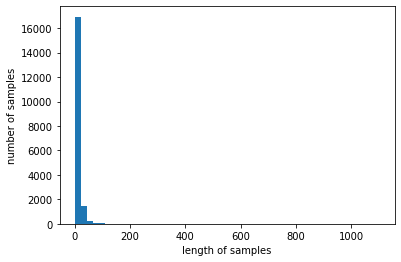

In [23]:
print('댓글의 최대 길이 :',max(len(l) for l in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [25]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 87.4146757679181


In [26]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.6565699658703


In [27]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.41894197952219


In [28]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.64547781569965


In [29]:
max_len = 40

X_train = pad_sequences(X_train, maxlen = max_len, padding='pre')
X_test = pad_sequences(X_test, maxlen = max_len, padding= 'pre')

# LSTM

In [30]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [44]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 데이터 손실이 4회 증가하면 조기 종료
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 저장
# validation_split : 훈련 데이터 중 몇%를 검증 데이터로 사용할 것인지

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
251/251 [==============================] - 36s 130ms/step - loss: 0.4289 - acc: 0.7980 - val_loss: 0.3415 - val_acc: 0.8523

Epoch 00001: val_acc improved from -inf to 0.85231, saving model to LSTM_model.h5
Epoch 2/15
251/251 [==============================] - 30s 118ms/step - loss: 0.2400 - acc: 0.8991 - val_loss: 0.3133 - val_acc: 0.8758

Epoch 00002: val_acc improved from 0.85231 to 0.87577, saving model to LSTM_model.h5
Epoch 3/15
251/251 [==============================] - 30s 118ms/step - loss: 0.1895 - acc: 0.9237 - val_loss: 0.3111 - val_acc: 0.8726

Epoch 00003: val_acc did not improve from 0.87577
Epoch 4/15
251/251 [==============================] - 29s 117ms/step - loss: 0.1631 - acc: 0.9347 - val_loss: 0.3137 - val_acc: 0.8771

Epoch 00004: val_acc improved from 0.87577 to 0.87710, saving model to LSTM_model.h5
Epoch 5/15
251/251 [==============================] - 30s 118ms/step - loss: 0.1450 - acc: 0.9425 - val_loss: 0.3133 - val_acc: 0.8806

Epoch 00005: val_a

In [ ]:
# 로컬에 파일 다운로드

from google.colab import files
files.download('LSTM_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# LSTM_model.h5 실행
loaded_model = load_model(route+'/model/LSTM_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

loaded_model.summary()

148/148 [==============================] - 4s 23ms/step - loss: 0.3339 - acc: 0.8743

 테스트 정확도: 0.8743
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1376500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,493,877
Trainable params: 1,493,877
Non-trainable params: 0
_________________________________________________________________


# 잘못 분류한 것 확인

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[8.2325935e-04],
       [7.6545799e-01],
       [1.5898049e-03],
       ...,
       [9.9688017e-01],
       [9.9349701e-01],
       [9.9951351e-01]], dtype=float32)

In [ ]:
test_df = pd.DataFrame(y_test)
pred_df = pd.DataFrame(y_pred)
test_df.columns = ['test']
pred_df.columns = ['pred']

In [ ]:
result = pd.concat([test_df, pred_df], axis=1)
result

,test,pred
0,0.0,0.000823
1,0.0,0.765458
2,0.0,0.001590
3,0.0,0.377784
4,0.0,0.953995
...,...,...
4705,1.0,0.997091
4706,1.0,0.999877
4707,1.0,0.996880
4708,1.0,0.993497


In [ ]:
for i in range(len(result)):
  if result['pred'][i] < 0.4:
    result['pred'][i] = 0
  elif result['pred'][i] > 0.7:
    result['pred'][i] = 1
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,test,pred
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,1.0
...,...,...
4705,1.0,1.0
4706,1.0,1.0
4707,1.0,1.0
4708,1.0,1.0


In [ ]:
copy = result.copy()
# result = copy.copy()

In [ ]:
for i in range(len(result)):
  if result['test'][i] == result['pred'][i]:
    result['test'][i] = np.nan
    result['pred'][i] = np.nan
test_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,test,pred
0,NaN,NaN
1,0.0,1.0
2,NaN,NaN
3,NaN,NaN
4,0.0,1.0
...,...,...
4705,NaN,NaN
4706,NaN,NaN
4707,NaN,NaN
4708,NaN,NaN


In [ ]:
result = result.dropna()
# result.reset_index(inplace=True, drop=True)
result

,test,pred
1,0.0,1.0
4,0.0,1.0
13,0.0,1.0
27,0.0,1.0
43,0.0,1.0
...,...,...
4621,1.0,0.0
4638,1.0,0.0
4659,1.0,0.0
4690,1.0,0.0


In [ ]:
pos_neg = [] # 긍정인데 부정으로 예측한 index
neg_pos = [] # 부정인데 긍정으로 예측한 index
for i in result.index:
  if result['test'][i] < result['pred'][i]: 
    # 긍정인데 부정으로 예측했을 때
    pos_neg.append(i)
  else:               
    # 부정인데 긍정으로 예측했을 때                
    neg_pos.append(i) 

In [ ]:
x_test = []
for i in range(len(X_test)):
  x_test.append(' '.join(X_test[i]))
x_test

['너무 소중한 목소리',
 '진짜 로 궁금한 거 사진 찍고 폰 왜 발 로 찬 거지',
 '수록 곡 퀄리티 장난 아니네 ㄷㄷ',
 '꿀쟁',
 '진짜 숨도 안 쉬 봣 다 ㅋㅋㅋ 말 존 나 하네',
 '음 유투 버 하면 하시겠는데',
 '살랑살랑 하는데도 그루브 달라 그냥 달라 천상 연예인 진짜',
 '뭔가 다르단 말 이야',
 '우울증 치료 제',
 '이쁘고 실력 까지 좋은 신 유빈 선수 응원 해요',
 '아 진짜 너무 매력 있다 ㅌㅋㅌㅌㅌㅌㅌㅌㅌㅋ',
 '무슨 단편영화 만들어놨네',
 '존 버 승리 다 이번 노래 다 너무 좋아 ㅏㅏ 어떻게 흑 흑 오열 중 ㅠㅠㅠㅠ 여름 듣기 너무 좋은',
 '진짜 이런 여자 만나고 싶구나',
 '머 야 개 재밌어 두 배 속 안 하고 다 봄',
 '개멋 져',
 '뭔가 웃기 다 그땐 몰랐고 젠 속죄 하고 훌훌 털어 버리면 대고',
 '진짜 대 박 이네 노래 짱 좋아',
 '부르다 마 않음 숨 차서 그 런가',
 '맘 찡하네요 엄마 마음',
 '아아 그렇군요 답변 해주셔서 감사해요',
 '무대 진짜 개 좋다고 ㅠㅠ',
 '그대 곁 있다면',
 '때 만 해도 엄청 어려 보이',
 '저 언니 사실 여린 언니 인데',
 '몇 십 분 짜리 영상 인데 쉴 새 없이 웃기 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋ 조회 수가 천백만',
 '존 나 옘브',
 '센 언니 아니라 열심히 사는 언니 다 진짜',
 '마지막 감동 이네 요',
 '초동 10만 장 넘게 나왔으면 국내 팬덤 강한 거 아닌가',
 'ㅋㅋㅋㅋ 탁구 졸 귀탱 이던 데',
 'ㅎㅎ 그 쵸 귀엽고 실력 짱 이고 앞 한국 탁구 댜 표 할 인재 감이죠',
 '무한도전 니깐 저렇게 모으지 예능 어벤져 스 ㅋㅋㅋㅋㅋ',
 '그걸 또 말 하는 님 더 귀 여 움',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 개 잘생겼다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 바라만 봐도 행복하네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 '오디오 안비 ㅋㅋㅋㅋ',
 '진짜 대 박 너무 사랑스러워',
 '마지막 까지 계시는 조끼 입으신 분 누구 예요',


In [ ]:
x_test = pd.DataFrame(x_test)
x_test.columns = ['comments']
x_test

,comments
0,너무 소중한 목소리
1,진짜 로 궁금한 거 사진 찍고 폰 왜 발 로 찬 거지
2,수록 곡 퀄리티 장난 아니네 ㄷㄷ
3,꿀쟁
4,진짜 숨도 안 쉬 봣 다 ㅋㅋㅋ 말 존 나 하네
...,...
4705,서인영 ㄹㅇ ㅋㅋㅋ 주제 모르네
4706,서인영 개꼰대 인성 쓰레기 이휘재 하위 호환 격 휘재 자기 보다 약해 보이는 사람 ...
4707,용호 형님 쵞오 유해진 좌좀 빨갱이 ㅇㅈ
4708,김제동 유튜브 시작 했은데 유재석 이효리 오픈 메세지 보냈다 놈 빨갱이 다


In [ ]:
result_ = []
for i in result.index:
  result_.append(x_test['comments'][i])
result_

['진짜 로 궁금한 거 사진 찍고 폰 왜 발 로 찬 거지',
 '진짜 숨도 안 쉬 봣 다 ㅋㅋㅋ 말 존 나 하네',
 '진짜 이런 여자 만나고 싶구나',
 '존 나 옘브',
 '얘 진짜 직업 정신 이랑 팬 사랑 투철 아무 공식 적 인정 열애설 이나 인성 논란 터진 적 없네',
 '자본주의 팔 ㅋㅋㅋ',
 '진짜 귀엽게 생긴 ㅋㅋ',
 '진짜 방송 3 사 연예 대상 이런 식이 면 좋을 텐데',
 '댓글 100 번 째당',
 'ㅅㅂ ㅋㅋㅋ 생각 하는 건 다 비슷하구나 ㅋㅋ 딱 그 생각 했는데 ㅋㅋㅋ 반가워요 동지 ㅋㅋㅋ',
 '저런 감독 이냐 독감 같은 놈 이지',
 '어이 없다 학교 다닐 때 배운 있냐 대가리 차갑게 굴리 따뜻한 가슴 없는 놈 감독 하면 그런 놈 하면 사기꾼 되지',
 '감독 아니라 돈 영혼 판 악마 악마 야',
 '미친 듯이 웃기 진짜',
 '존 나 감성 충만 유튜버 된 것 같다가 거울 보고 현 타 옴 ㅎ',
 '착시 현 상임 요',
 '뭐 야 집 얼굴 하네',
 'ㅁㅊ 개 존잘',
 '딱 고등학교 에서 잘생겼다고 다니는 친구 처럼 생겼다',
 '정직하게 살자 ㅋㅋㅋㅋ 아니에 욤',
 'ㅁㅊㅁㅊ 대 존',
 '변명 하는 습관 되 버렸네',
 '하느님 하사 우리나라 만 쎄',
 '정유진 아닠 ㅋ',
 '연예인 중 연예인',
 '휘성 군 3 이라 힘들지 며 칠 머리 시키고 집 들어가셔요',
 '차 탈 때 쪽 으로만 타는 건가 ㅋ 팔 한쪽 부자연스러워 잘못 하면 사고나겠다 사고 나겠어 ㅋㅋ',
 '지하철 남자 위험했다 쓰러지면서 뒤 머리 부딪혀 뇌출혈 생기 면',
 '그게 뭔 뜻 죠 대영제국 이슬람 화 된 거 보니 끔찍하네요 그 악명 높은 조선족 유일하게 벌벌 떨면서 무서워하는 끝판 왕 무슬림 죠',
 '사람 문재인 찍은 거 봤냐',
 '교육 처절함을 느낀다',
 '똑같은 말 또 써놓고 질질 끌다 마지막 유 허무하게 알려 줌',
 '교육자 야 양 아치 아냐 남인 생가지 장난 치지마',
 '경찰 사이다 ㅋ',
 '보는 내 육두문자 구수하게 튀나오는데 

In [ ]:
len(result_)

616

In [ ]:
result__ = pd.DataFrame(result_)
result__.to_csv(route+'잘못예측한데이터.csv', encoding='utf-8-sig')

# BiLSTM

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('BiLSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/20
51/51 [==============================] - 25s 411ms/step - loss: 0.5311 - acc: 0.7323 - val_loss: 0.3889 - val_acc: 0.8497

Epoch 00001: val_acc improved from -inf to 0.84968, saving model to BiLSTM_model.h5
Epoch 2/20
51/51 [==============================] - 20s 391ms/step - loss: 0.2982 - acc: 0.8836 - val_loss: 0.3238 - val_acc: 0.8650

Epoch 00002: val_acc improved from 0.84968 to 0.86505, saving model to BiLSTM_model.h5
Epoch 3/20
51/51 [==============================] - 20s 385ms/step - loss: 0.2307 - acc: 0.9116 - val_loss: 0.3092 - val_acc: 0.8684

Epoch 00003: val_acc improved from 0.86505 to 0.86843, saving model to BiLSTM_model.h5
Epoch 4/20
51/51 [==============================] - 20s 385ms/step - loss: 0.1598 - acc: 0.9407 - val_loss: 0.3131 - val_acc: 0.8752

Epoch 00004: val_acc improved from 0.86843 to 0.87519, saving model to BiLSTM_model.h5
Epoch 5/20
51/51 [==============================] - 19s 382ms/step - loss: 0.1393 - acc: 0.9483 - val_loss: 0.3247 - va

In [ ]:
# 로컬에 파일 다운로드

from google.colab import files
files.download('BiLSTM_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_model = load_model(route+'/model/BiLSTM_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

128/128 [==============================] - 3s 16ms/step - loss: 0.3369 - acc: 0.8696
테스트 정확도: 0.8696


# 모델 테스트

In [45]:
loaded_model = load_model(route+'/model/LSTM_model.h5')
# loaded_model = load_model(route+'/model/BiLSTM_model.h5')

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print(score)
  if(score > 0.5):
    print("{:.2f}% 확률로 부정 댓글입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 긍정 댓글입니다.\n".format((1 - score) * 100))

In [46]:
sentiment_predict('쓰레기 새끼들아')

0.9999197125434875
99.99% 확률로 부정 댓글입니다.



In [48]:
sentiment_predict('진짜 예뻐요')

0.014700204133987427
98.53% 확률로 긍정 댓글입니다.

